# Экспериментальное исследование алгоритмов решения задачи достижимости с КС ограничениями

Исследование посвящено анализу производительности различных алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными (КС) ограничениями: алгоритма Хеллингса, матричного алгоритма, тензорного алгоритма и сравнению этих алгоритмов между собой и с алгоритмами решения задачи достижимости с регулярными ограничениями (частный случай КС-ограничений): тензорным алгоритмом и алгоритмом, основанном на синхронном обходе в ширину.

## Исследуемые алгоритмы

### Алгоритмы решения задачи достижимости между всеми парами вершин с КС ограничениями

#### Алгоритм Хеллингса

**Идея**: работаем с грамматикой в обобщённой нормальной форме Хомского (ОНФХ), для каждого нетерминала храним, из каких вершин в какие вершины выводимы пути, на каждой итерации берём один выводимый путь, который ранее ещё не брали, и пытаемся "приклеить" к нему другие ранее найденные выводимые пути.

**Описание**

Инициализация состоит из двух пунктов:
  1. Для продукций вида $(A → a) ∈ P$, где $A ∈ N, a ∈ Σ$ регистрируем факт выводимости из $A$ пути из $u$ в $v$, где $u, v ∈ V$ такие, что $(u, a, v) ∈ E$
  2. Для продукций вида $(A → ε) ∈ P$, где $A ∈ N$ регистрируем факт выводимости из $A$ пути между вершинами $v$ и $v$, где $v ∈ V$
   
На каждом шаге
  1. Рассматриваем зарегистрированный ранее, но не рассмотренный ни на одном из шагов, факт выводимости из $A ∈ N$ пути из $u ∈ V$ в $v ∈ V$
  2. Для всех таких ранее зарегистрированных фактов выводимости из $A' ∈ N$ пути из $u' ∈ V$ в $v' ∈ V$ таких, что $v' = u$ и $(B → A' A) ∈ P$ регистрируется факт выводимости из $B$ пути из $u'$ в $v$, если он ранее не был зарегистрирован
  3. Для всех таких ранее зарегистрированных фактов выводимости из $A' ∈ N$ пути из $u' ∈ V$ в $v' ∈ V$ таких, что $v = u'$ и $(B → A A') ∈ P$ регистрируется факт выводимости из $B$ пути из $u в v'$, если он ранее не был зарегистрирован

Алгоритм завершается, когда не осталось нерассмотренных зарегистрированных фактов выводимости путей

**Детали реализации**

Для хранения зарегистрированных фактов достижимости (переменная `r`) используется [`set`](https://docs.python.org/3/library/stdtypes.html#set)

Для хранения необработанных фактов достижимости (переменная `m`) используется [`deque`](https://docs.python.org/3/library/collections.html#collections.deque)

Для реализации итерации с условием (в частности, циклов со словами "таких что") используется [`dict`](https://docs.python.org/3/library/stdtypes.html#dict)

```
function hellingsCFPQ(G = ⟨Σ, N, P, S⟩, Ꮹ = ⟨V, E, L⟩)
  r ← {(Ni, v, v) | v ∈ V ∧ (Ni → ε) ∈ P} ∪ {(Ni, v, u) | (v, t, u) ∈ E ∧ (Ni → t) ∈ P}
  m ← r
  while m ≠ ∅ do
    (A, v, u) ← m.pick()
    for (A′, v′, v) ∈ r do
      for (B → A′A) ∈ P таких что ((B, v′, u) ∉ r) do
        m ← m ∪ {(B, v′, u)}
        r ← r ∪ {(B, v′, u)}
    for (A′, u, v′) ∈ r do
      for (B → AA′) ∈ P таких что ((Nk, v, v′) ∉ r) do
      m ← m ∪ {(B, v, v′)}
      r ← r ∪ {(Nk, v, v′)}
  return r
```

#### Матричный алгоритм

**Идея**: работаем с грамматикой в обобщённой нормальной форме Хомского (ОНФХ), храним матрицу достижимости, элементы которой множества нетерминалов, из которых выводимы пути между соответствующими вершинами, итерация алгоритма --- прибавление к матрице достижимости её квадрата (умножение производится над полукольцом со специально выбранными операциями, зависящими от грамматики)

**Описание**

Получаем первое приближение матрицы достижимости $M$, элементы которой множества нетерминалов, из матрицы смежности графа:
  1. Заменив, рёбра с меткой $a ∈ Σ$ на все нетерминалы $A ∈ N$ такие, что $(A → a) ∈ P$
  2. Для нетерминалов $A ∈ N$ таких, что $(A → ɛ) ∈ P$, добавив петли с меткой $A$ для всех вершин

Далее пока матрица меняется прибавляем к ней её квадрат, выполняя умножение матриц над полукольцом, в котором
  1. Сложение --- это объединение множеств
  2. Поэлементное умножение определено следующим образом:
  $S1 * S2 = \{N0 ... Nm\} * \{N'0 ... N'l\} = \{A | (A → Ni N'j) ∈ P\}$

**Детали реализации**

Для представления матриц, элементы которых множества, используется булева декомпозиция

Для матричных операций используется библиотека разреженной линейной алгебры [pygraphblas](https://github.com/Graphegon/pygraphblas)

```
function matrixCFPQ(G = (N, Σ, P, S), Ꮹ = (V, E))
  n ← |V|
  T ← {T_Ai | Ai ∈ N, T_Ai is a matrix n × n, T_Ai[k][l] ← false}
  for all (i, x, j) ∈ E, Ak | (Ak → x) ∈ P do T_Ak[i][j] ← true
  for Ak | (Ak → ε) ∈ P do T_Ak[i][i] ← true
  while any matrix in T is changing do
    for (Ai → AjAk) ∈ P do T_Ai ← T_Ai + (T_Aj × T_Ak)
  return T
```

#### Тензорный алгоритм

**Идея**: работаем с рекурсивным конечным автоматом (РКА), на каждой итерации с помощью произведения Кронекера находим пересечение графа и РКА, как будто это конечный автомат над смешанным алфавитом терминалов и нетерминалов, после этого добавляем в граф ребра с метками-нетерминалами для тех пар вершин, для которых были найдены пути, выводимые из этих нетерминалов.

**Описание**

Для нетерминалов $A ∈ N$, порождающих $ɛ$ сразу добавляем в граф петли с меткой $A$ для всех вершин

На каждой итерации:
  1. Вычисляем произведение Кронекера матрицы смежности РКА и текущей матрицы смежности графа
  2. Вычисляем транзитивное замыкание полученной матрицы с помощью быстрого возведения в степень
  3. Для каждого ребра транзитивного замыкания из $(a, u)$ в $(b, v)$, где $a$ и $b$ --- соответственно стартовое и финальное состояния бокса РКА, соответствующего нетерминалу $A ∈ N$ добавляем в граф ребро с меткой $A$ из $u$ в $v$

Алгоритм завершается, когда на очередной итерации не происходит изменений графа

**Детали реализации**

Для представления матриц, элементы которых множества, используется булева декомпозиция

Для матричных операций используется библиотека разреженной линейной алгебры [pygraphblas](https://github.com/Graphegon/pygraphblas)

Из-за особенностей работы с разряженными матрицами, рёбра в граф добавляются пачками в конце итераций цикла `while`, а не по одному

Итерация по ненулевым элементам матрицы осуществляется с помощью функций библиотеки разряженной алгебры, а не путём перебора всех элементов

После построения РКА, его боксы детерминизируются и минимизируются
```
function tensorCFPQ(G = (N, Σ, P, S), Ꮹ = (V, E))
  R ← рекурсивный автомат для G
  N ← нетерминальный алфавит для R
  S ← стартовые состояния для R
  F ← конечные состояния для R
  M1 ← матрица смежности R
  M2 ← матрица смежности Ꮹ
  for Ni ∈ N do
    if Ni is nullable then
      for all j ∈ V : M2[j, j] ← M2[j, j] ∪ {Ni} ▷ Добавим петли для нетерминалов, выводящих ε
  while матрица M2 изменяется do
    M3 ← M1 ⊗ M2 ▷ Пересечение графов
    tC3 ← transitiveClosure(M3)
    n ← количество строк и столбцов матрицы M3 ▷ размер матрицы M3 = n × n
    for i ∈ 0..n do
      for j ∈ 0..n do
        if tC3[i, j] then
          s ← стартовая вершина ребра tC3[i, j]
          f ← конечная вершина ребра tC3[i, j]
          if s ∈ S and f ∈ F then
          x, y ← getCoordinates(i, j)
          M2[x, y] ← M2[x, y] ∪ {getNonterminals(s, f)}
  return M2
```

### Алгоритмы решения задачи достижимости с регулярными ограничениями (частный случай КС-ограничений)

#### Тензорный алгоритм

**Идея**: с помощью произведения Кронекера находим матрицу смежности конечного автомата, распознающего пересечение языков, задаваемых графом и запросом, после этого находим транзитивное замыкание этой матрицы.

**Описание**

1. С помощью произведения Кронекера матрицы смежности входного графа и матрицы смежности конечного автомата, соответствующего входному регулярному выражению, получается матрица смежности конечного автомата, распознающего пересечение языков, задаваемых входными графом и регулярным выражением

2. Полученная матрица смежности редуцируется до одной булевой матрицы с единицами на месте непустых множеств и нулями на месте --- пустых

3. С помощью быстрого возведения в степень находится транзитивное замыкание полученной булевой матрицы

4. Перебор всех ненулевых элементов полученной на предыдущем шаге матрицы позволяет определить все пары вершин $(u, v)$ входного графа такие, что вершина $v$ достижима из вершины $u$ с данным регулярным ограничением

**Детали реализации**

Для представления матриц, элементы которых множества, используется булева декомпозиция

Для матричных операций используется библиотека разреженной линейной алгебры [pygraphblas](https://github.com/Graphegon/pygraphblas)

Итерация по ненулевым элементам матрицы осуществляется с помощью функций библиотеки разряженной алгебры, а не путём перебора всех элементов

Конечный автомат для запроса после построения детерминизируется и минимизируется
```
function tensorRPQ(R, Ꮹ = (V, E))
  FA ← конечный автомат для R
  M1 ← матрица смежности FA
  M2 ← матрица смежности Ꮹ
  M3 ← M1 ⊗ M2 ▷ Пересечение графов
  tC3 ← transitiveClosure(M3)
  r ← {}
    for i ∈ 0..n do
      for j ∈ 0..n do
        if tC3[i, j] then
          s ← стартовая вершина ребра tC3[i, j]
          f ← конечная вершина ребра tC3[i, j]
          if s ∈ FA.S and f ∈ FA.F then
          x, y ← getCoordinates(i, j)
          r ← r ∪ {getNonterminals(s, f)}
  return r
```

#### Синхронный обход в ширину

**Замечание**: задача достижимости решается данным алгоритмом для заданного множества стартовых вершин либо для всех сразу, либо по отдельности для каждой. В этом исследовании, чтобы ответить на вопрос о том, может ли использование специализированных алгоритмов для регулярных ограничений быть предпочтительным, рассматривается наиболее благоприятный для данного алгоритма нетривиальный случай, когда стартовая вершина только одна. В этом случае разницы между разделённой по стартовым вершинам и объеденной версией алгоритма нет, поэтому далее описана только вторая.

**Идея**: синхронно обходим в ширину граф и конечный автомат, храним, какие пары вершин графа и конечного автомата, соответствующего запроса, достигнуты и какие были впервые достигнуты только что (фронт).

**Описание**
1. Задача решается с помощью синхронного обхода в ширину входного графа и конечного автомата, соответствующего входному регулярному выражению
   - Во время синхронного обхода в ширину поддерживаются две булевы матрицы
      - `visited`, элемент в $i$-ой строке и $j$-ом столбце которой содержит единицу, если в ходе синхронного обхода была достигнута $j$-ая вершина графа в то время, как автомат находился в $i$-ом состоянии
      - `front`, элемент в $i$-ой строке и $j$-ом столбце которой содержит единицу, если **на предыдущем шаге** синхронного обхода была достигнута $j$-ая вершина графа в то время, как автомат находился в $i$-ом состоянии
2. Изначально в обеих матрицах на пересечении $i$-ой строки и $j$-ого столбца стоит единица, если $i$-ое состояние автомата является начальным, а $j$-ая вершина графа входит в стартовое множество
3. На каждом шаге синхронного обхода для получения нового `front`-а производится умножение матрицы `front` на матрицу смежности графа и переупорядочивание её строк в соответствии с матрицей смежности автомата, после чего к новому фронту применяется комплиментарная маска `visited` и он прибавляется к матрице `visited`
4. Процесс продолжается, пока `front` не станет нулевым
5. В итоге индексы достижимых с данным регулярным ограничением вершин --- это индексы тех столбцов матрицы `visited`, которые на пересечение со строками, соответствующими конечным состояниям автомата, содержат хотя бы одну единицу

**Детали реализации**

Для представления матриц, элементы которых множества, используется булева декомпозиция

Для матричных операций используется библиотека разреженной линейной алгебры [pygraphblas](https://github.com/Graphegon/pygraphblas)

```
function bfsRPQ(R, G = ⟨V, E⟩, Vsrc)
  D ← BoolR ⊕ BoolG ▷ Построение матриц D
  Front ← CreateMatrix(|Q|, |V|) ▷ Построение матрицы M (фронт обхода)
  Front ← SetStartVerts(M, Vsrc) ▷ Заполнение нач. вершин
  Visited ← Front
  repeat
    Front′ ← 0 ▷ Инициализация нового фронта нулями
    for all a ∈ Σ do
      Temp ← Front × D[a] ▷ Матр. умножение в бул. полукольце
      Temp ← TransformRows(Temp) ▷ Приведение Temp к виду Front
      Front′ ← Front′ + Temp ▷ Матр. сложение в бул. полукольце
    Front ← Front′ ⟨¬Visited⟩ ▷ Применение комплементарной маски
    Visited ← Visited + Front
  until Front = 0
  Visited ← zeroNonFinal(Visited, R) ▷ Обнуление строк для нефинал. сост. R
  return Visited.reduceVector() ▷ Сложение по столбцам
```

## Исследовательские вопросы

1. Какой из трёх алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными (КС) ограничениями обладает лучшей производительностью?

2. Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

## Постановка экспериментов

### Оборудование

GPU не подключался, так как [pygraphblas](https://github.com/Graphegon/pygraphblas) в качестве реализации стандарта GraphBLAS использует [SuiteSparse:GraphBLAS](https://github.com/DrTimothyAldenDavis/GraphBLAS), поддержка GPU для которого всё ещё в процессе разработки

In [ ]:
! printf '========== OS  ==========\n'
!grep '^NAME=' /etc/os-release
!grep '^VERSION=' /etc/os-release

! printf '\n========== CPU ==========\n'
! lscpu | grep -E 'Architecture|Model name|Thread\(s\)|Core\(s\)|MHz'

! printf '\n========== GPU ==========\n-\n'
! nvidia-smi -L | grep -o 'NVIDIA .* (' | sed 's/ (//'
! nvidia-smi | grep -o 'CUDA Version: [0-9.]*'
! nvidia-smi --query-gpu=memory.total --format=csv | grep '[0-9]* MiB'

! printf '\n========== RAM ==========\n'
! free -m

========== OS  ==========
NAME="Ubuntu"
VERSION="18.04.6 LTS (Bionic Beaver)"

========== CPU ==========
Architecture:        x86_64
Thread(s) per core:  2
Core(s) per socket:  1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
CPU MHz:             2199.998

========== GPU ==========
-

========== RAM ==========
              total        used        free      shared  buff/cache   available
Mem:          12985        1390       10502           1        1092       11414
Swap:             0           0           0


### Подготовка окружения (для запуска в Google Colab)

#### Установка Python 3.8 (для Google Colab)

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

#### Клонирование GitHub репозитория с реализациями алгоритмов и установка зависимостей

In [ ]:
!git clone https://github.com/IlyaMuravjov/formal-lang-course.git
%cd formal-lang-course
!git checkout task12
!git pull
!pip install -r requirements.txt
!pip install matplotlib

##### **Чтобы продолжить в Google Colab, перезагрузите страницу для обновления используемой версии Python и перезапустите RUNTIME для обновления доступных библиотек**

#### Импорты

In [ ]:
import sys
sys.path.insert(0, "/content/formal-lang-course")

In [ ]:
import math
import textwrap
import timeit
import logging
import pandas as pd
import cfpq_data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pyformlang

from typing import Callable
from typing import List
from typing import Tuple
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
from cfpq_data import add_reverse_edges
from cfpq_data import generate_multiple_source
from IPython.display import display, HTML

import project.with_pygraphblas.bool_decomposed_nfa

from project.fa_utils import regex_to_minimal_dfa
from project.graph_utils import get_graph
from project.graph_utils import get_graph_data
from project.graph_utils import to_graph_data
from project.regular_path_query import regular_path_query_all_pairs
from project.regular_path_query import regular_path_query_multiple_source
from project.context_free_path_query import filtered_cfpq_with_hellings
from project.ecfg import ECFG
from project.time_utils import time_limit
from project.time_utils import timeit_with_time_limit
from project.time_utils import TimeoutException
from project.with_pygraphblas.context_free_path_query import filtered_cfpq_with_matrix
from project.with_pygraphblas.context_free_path_query import filtered_cfpq_with_tensor

#### Прочие настройки

Отключение логирования уровня `INFO`, чтобы не засорять выходной поток комментариями происходящего библиотекой CFPQ_Data (опционально)

In [ ]:
logging.disable(logging.INFO)

Объявление вспомогательных функций

In [ ]:
def finites(iter):
    return (x for x in iter if np.isfinite(x))

def distinct_list(elms):
    return list(dict.fromkeys(elms))

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n", "<br>")))

Отключение ограничения размера таблиц (опционально)

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### Описание набора данных

#### Графы

Графы выбирались из набора данных [CFPQ_Data](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html). Чтобы повысить репрезентативности входных данных, было решено использовать графы различных размеров и возникающие при решении различных прикладных задач: анализ RDF, анализ указателей в С, анализ Java-программ.

Далее приведена таблица с характеристиками выбранных графов.

In [ ]:
GRAPHS = [
    ("wc", "C", dict()),
    ("generations", "RDF", dict()),
    ("bzip", "C", dict()),
    ("pr", "C", dict()),
    ("pizza", "RDF", dict()),
    ("gzip", "C", dict()),
    ("pathways", "RDF", dict()),
    ("lusearch", "Java", {"num_fields": 348}),
    ("sunflow", "Java", {"num_fields": 232}),
    ("enzyme", "RDF", dict()),
]

In [ ]:
def full_graph_type_name(typ: str, extra_data: dict) -> str:
    if typ == "C":
        return "C alias analysis"
    elif typ == "RDF":
        return "RDF graph analysis"
    elif typ == "Java":
        return f"Java program analysis ({extra_data['num_fields']} fields)"
    else:
        raise ValueError("Unknown graph type")

In [ ]:
pd.DataFrame(
    [
        (
            name,
            full_graph_type_name(typ, extra_data),
            get_graph(name).number_of_nodes(),
            get_graph(name).number_of_edges() * 2,
        )
        for name, typ, extra_data in GRAPHS
    ],
    columns=[
        "Name",
        "Application",
        "Num node",
        "Num edges (including reversed edges)",
    ],
)

,Name,Application,Num node,Num edges (including reversed edges)
0,wc,C alias analysis,332,538
1,generations,RDF graph analysis,129,546
2,bzip,C alias analysis,632,1112
3,pr,C alias analysis,815,1384
4,pizza,RDF graph analysis,671,3960
5,gzip,C alias analysis,2687,4586
6,pathways,RDF graph analysis,6238,24726
7,lusearch,Java program analysis (348 fields),15774,29988
8,sunflow,Java program analysis (232 fields),15464,31914
9,enzyme,RDF graph analysis,48815,173086


Графы больших размеров не рассматривались из-за ограничений по времени и по памяти

#### Запросы

##### Контекстно-свободные запросы

В качаестве КС-запросов использовались грамматики из раздела "Canonical grammars" в описании соответствующих графов, так как именно эти грамматики используются для решения прикладных задач.

Так как тензорный алгоритм может работать с расширенными КС-грамматиками (ECFG), то те запросы, для которых это уместно, были также представлены в виде расширенных КС-грамматик.

Далее приведена таблица с представлениями выбранных КС-запросов. Запрос для анализа Java программ приведён в таблице только для программы с двумя полями, во время эксперимента данный запрос расширялся, в зависимости от того, сколько полей используется анализируемой программой.

In [ ]:
C_ALIAS_QUERIES = [
    (
        "C alias",
        "S -> d_r V d\n"
        "V -> V1 V2 V3\n"
        "V1 -> epsilon\n"
        "V1 -> V2 a_r V1\n"
        "V2 -> epsilon\n"
        "V2 -> S\n"
        "V3 -> epsilon\n"
        "V3 -> a V2 V3",
        {"S": "d_r V d", "V": "((S|epsilon) a_r)* (S|epsilon) (a (S|epsilon))*"},
    )
]

RDF_QUERIES = [
    (
        "RDF 1",
        "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf\n"
        "S -> type_r S type | type_r type",
        None,
    ),
    ("RDF 2", "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf\n", None),
    ("RDF 3", "S -> type_r S type | type_r type", None),
]

def java_points_to_queries(num_fields: int):
    return [
        (
            f"Java points to ({num_fields} fields)",
            "S -> PTh alloc\n"
            "PTh -> epsilon\n"
            "PTh -> assign PTh\n"
            "FT -> alloc_r FTh\n"
            "FTh -> epsilon\n"
            "FTh -> assign_r FTh\n"
            "Al -> S FT\n"
            + "\n".join(
                f"PTh -> load_{i} Al store_{i} PTh\n"
                f"FTh -> store_{i}_r Al load_{i}_r FTh"
                for i in range(num_fields)
            ),
            {
                "S": "(assign|"
                + "|".join(f"load_{i} Al store_{i}" for i in range(num_fields))
                + ")* alloc",
                "Al": "S FT",
                "FT": "alloc_r (assign_r|"
                + "|".join(f"store_{i}_r Al load_{i}_r" for i in range(num_fields))
                + ")*",
            },
        )
    ]

def context_free_queries_for_graph(typ: str, extra_data: dict):
    if typ == "C":
        return C_ALIAS_QUERIES
    elif typ == "RDF":
        return RDF_QUERIES
    elif typ == "Java":
        return java_points_to_queries(extra_data["num_fields"])
    else:
        raise ValueError("Unknown graph type")

In [ ]:
pretty_print(
    pd.DataFrame(
        [
            (
                name,
                cfg,
                "-"
                if ecfg is None
                else "\n".join(
                    [f"{head} -> {tail}" for head, tail in ecfg.items()]
                ),
            )
            for name, cfg, ecfg in C_ALIAS_QUERIES
            + RDF_QUERIES
            + java_points_to_queries(2)
        ],
        columns=["Name", "CFG", "ECFG"],
    )
)

,Name,CFG,ECFG
0,C alias,S -> d_r V dV -> V1 V2 V3V1 -> epsilonV1 -> V2 a_r V1V2 -> epsilonV2 -> SV3 -> epsilonV3 -> a V2 V3,S -> d_r V dV -> ((S|epsilon) a_r)* (S|epsilon) (a (S|epsilon))*
1,RDF 1,S -> subClassOf_r S subClassOf | subClassOf_r subClassOfS -> type_r S type | type_r type,-
2,RDF 2,S -> subClassOf_r S subClassOf | subClassOf_r subClassOf,-
3,RDF 3,S -> type_r S type | type_r type,-
4,Java points to (2 fields),S -> PTh allocPTh -> epsilonPTh -> assign PThFT -> alloc_r FThFTh -> epsilonFTh -> assign_r FThAl -> S FTPTh -> load_0 Al store_0 PThFTh -> store_0_r Al load_0_r FThPTh -> load_1 Al store_1 PThFTh -> store_1_r Al load_1_r FTh,S -> (assign|load_0 Al store_0|load_1 Al store_1)* allocAl -> S FTFT -> alloc_r (assign_r|store_0_r Al load_0_r|store_1_r Al load_1_r)*


##### Регулярные запросы

В качестве регулярных запросов использовались четыре различных регулярных языка, два из которых содержат конечное число слов и два -- бесконечное.

Каждый из выбранных регулярных языков был представлен тремя способами: в виде регулярного выражения, КС-грамматики и расширенной КС-грамматики.

При примении выбранных запросов к конкретным графам, символ `'a'` заменялся на наиболее часто встречаемую в графе метку рёбер, а символ `'b'` --- на вторую наиболее встречаемую.

Далее приведена таблица с представлениями выбранных регулярных запросов.

In [ ]:
REGULAR_QUERIES: List[Tuple[str, str, str]] = [
    ("a*", "term#a*", "S -> term#a S | epsilon"),
    (
        "(a|b)*.a.(a|b)*",
        "(term#a|term#b)*.term#a.(term#a|term#b)*",
        "S -> A term#a A \n A -> term#a A | term#b A | epsilon",
    ),
    ("a.(a|b)", "term#a (term#a|term#b)", "S -> term#a A \n A -> term#a | term#b"),
    (
        "a^16",
        16 * "term#a ",
        "S -> A1 A1 \n A1 -> A2 A2 \n A2 -> A3 A3 \n A3 -> term#a term#a",
    ),
]

def regular_queries_with_symbols(symbols: List[str]) -> List[Tuple[str, str, str]]:
    return [
        (
            query_name,
            regex_template.replace("term#a", symbols[0]).replace(
                "term#b", symbols[1]
            ),
            cfg_template.replace("term#a", symbols[0]).replace(
                "term#b", symbols[1]
            ),
        )
        for (query_name, regex_template, cfg_template) in REGULAR_QUERIES
    ]

def regular_queries_for_graph(graph: nx.Graph) -> List[Tuple[str, str, str]]:
    graph_data = to_graph_data(graph)
    sorted_labels = sorted(
        graph_data.label_occurrences,
        key=lambda label: (-graph_data.label_occurrences[label], label),
    )
    return regular_queries_with_symbols(sorted_labels)

In [ ]:
pretty_print(
    pd.DataFrame(
        [
            (name, regex, cfg, "S -> " + regex)
            for name, regex, cfg in regular_queries_with_symbols(["a", "b"])
        ],
        columns=["Name", "Regex", "CFG", "ECFG"],
    )
)

,Name,Regex,CFG,ECFG
0,a*,a*,S -> a S | epsilon,S -> a*
1,(a|b)*.a.(a|b)*,(a|b)*.a.(a|b)*,S -> A a A A -> a A | b A | epsilon,S -> (a|b)*.a.(a|b)*
2,a.(a|b),a (a|b),S -> a A A -> a | b,S -> a (a|b)
3,a^16,a a a a a a a a a a a a a a a a,S -> A1 A1 A1 -> A2 A2 A2 -> A3 A3 A3 -> a a,S -> a a a a a a a a a a a a a a a a


### Описание замеров

Число повторов замеров для одних и тех же начальных условий определялось следующей таблицей.

| Продолжительность одного запуска | Число запусков |
|----------------------------------|----------------|
| 0-3 минуты                       | 10             |
| 3-5 минут                        | 5              |
| 5-10 минут                       | 3              |
| 10-15 минут                      | 2              |
| >15 минут                        | 0              |

Работа алгоритма прерывалась в случае, когда заканчивалась оперативная память или время одного запуска превышало $15$ минут.

Для каждой группы замеров с одними и теми же начальными условиями находились выборочное среднее и стандартное отклонение.

Перед замером времени работы выполнялся тестовый прогон для проверки корректности работы алгоритма при данных начальных условиях путём сравнения результата его работы с результатом работы других алгоритмов, запущенных ранее на тех же входных данных, если среди них есть такие, которые завершились за 15 минут.

Для тех запросов, которые могут быть более компактно представлены в виде расширенной КС-грамматики, то есть для всех запросов, кроме запросов для анализа RDF графов, время работы тензорного алгоритма замерялось дважды: для обычной и для расширенной КС-грамматик.

#### Определения того, какой из трёх алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными (КС) ограничениями обладает лучшей производительностью

Для определения того, какой из трёх алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными (КС) ограничениями обладает лучшей производительностью, было замерено время работы алгоритма Хеллингса, матричного алгоритма и тензорного алгоритма на выбранных десяти графах с использованием для каждого графа его канонических КС-запросов и четырёх выбранных ранее регулярных запросов.

К графам производились только их канонические КС-запросы, так именно решение задачи для комбинаций графа и его канонического запроса является практически полезным.

#### Определение того, имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений или всё же лучше использовать специализированные алгоритмы для регулярных ограничений

Для определения того, имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС-ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений, было замерено время работы всех рассмотренных ранее алгоритмов на всех комбинациях выбранных графов и регулярных запросов.

Перебор всех комбинаций графов и регулярных запросов был произведён для проведения максимально полного анализа.

В отличие от остальных алгоритм синхронного обхода в ширину решает задачу достижимости для заданного множества стартовых вершин, поэтому для определения того может ли использование этого алгоритма быть целесообразным, рассматривался наиболее благоприятный для него нетривиальный случай, когда стартовая вершина только одна. Для воспроизводимости в качестве стартовой вершины всегда бралась $115$-ая вершина.

Рассмотрения наиболее благоприятного для алгоритма синхронного обхода в ширину нетривиального случая достаточно, так как:
1. Если даже в этом случае этот алгоритм медленнее других, то в остальных случаях он будет ещё медленнее
2. Если в этом случае алгоритм быстрее других, этого достаточно, чтобы утверждать, что его использование может иметь смысл в отдельных случаях

### Код для проведения эксперимента

In [ ]:
CFPQ_ALGORITHMS = [
    ("hellings cfpq", lambda cfg, graph: filtered_cfpq_with_hellings(cfg, graph)),
    ("matrix cfpq", lambda cfg, graph: filtered_cfpq_with_matrix(cfg, graph)),
    ("tensor cfpq", lambda cfg, graph: filtered_cfpq_with_tensor(cfg, graph)),
]

CFPQ_TENSOR_WITH_ECFG_QUERY_ALGORITHM_NAME = "tensor cfpq with ecfg query"

SINGLE_SOURCE_START = 115

RPQ_ALGORITHMS = [
    (
        algorithm_name,
        lambda regex, cfg, graph, algorithm_impl=algorithm_impl: algorithm_impl(
            cfg, graph
        ),
    )
    for algorithm_name, algorithm_impl in CFPQ_ALGORITHMS
] + [
    (
        CFPQ_TENSOR_WITH_ECFG_QUERY_ALGORITHM_NAME,
        lambda regex, _, graph: filtered_cfpq_with_tensor(
            ECFG.from_productions({"S": regex}), graph
        ),
    ),
    (
        "tensor rpq",
        lambda regex, _, graph: regular_path_query_all_pairs(
            regex,
            graph,
            bool_decomposed_nfa_cls=project.with_pygraphblas.bool_decomposed_nfa.BoolDecomposedNFA,
        ),
    ),
    (
        "sync bfs rpq for single source",
        lambda regex, _, graph: regular_path_query_multiple_source(
            regex,
            graph,
            start_states={SINGLE_SOURCE_START},
            bool_decomposed_nfa_cls=project.with_pygraphblas.bool_decomposed_nfa.BoolDecomposedNFA,
        ),
    ),
]

TIME_LIMIT_SECS = 15 * 60
REPEATS = 10

In [ ]:
# values are tuples of:
# - graph_name
# - query_name
# - algorithm_name
# - mean time in seconds
# - standard deviation in seconds
# - max time in seconds
res = []

for (graph_name, graph_typ, graph_extra_data) in GRAPHS:
    graph = add_reverse_edges(get_graph(graph_name))

    def run_experiments_for_query(
        query_name: str, algorithms: List[Tuple[str, Callable]]
    ):
        control_result = None
        for (algorithm_name, algorithm_impl) in algorithms:
            if graph_name == "enzyme" and (
                (
                    query_name == "RDF 1"
                    or query_name == "RDF 2"
                    or query_name == "RDF 3"
                    or query_name == "a*"
                    or query_name == "(a|b)*.a.(a|b)*"
                )
                or (
                    query_name == "a.(a|b)"
                    and (
                        algorithm_name == "hellings cfpq"
                        or algorithm_name == "matrix cfpq"
                        or algorithm_name == "tensor cfpq"
                        or algorithm_name == "tensor cfpq with ecfg query"
                        or algorithm_name == "tensor rpq"
                    )
                )
            ):
                continue
            try:
                with time_limit(TIME_LIMIT_SECS):
                    cur_result = algorithm_impl()
                    if algorithm_name == "sync bfs rpq for single source":
                        assert (
                            control_result is None
                            or {
                                finish
                                for (start, finish) in control_result
                                if start == SINGLE_SOURCE_START
                            }
                            == cur_result
                        )
                    elif control_result is None:
                        control_result = cur_result
                    else:
                        assert control_result == cur_result
            except Exception as e:
                if not isinstance(e, TimeoutException):
                    print(e)
                res.append(
                    (
                        graph_name,
                        query_name,
                        algorithm_name,
                        np.nan,
                        np.nan,
                        float("inf"),
                    )
                )
                continue
            times = []
            for i in range(REPEATS):
                time = timeit_with_time_limit(algorithm_impl, TIME_LIMIT_SECS)
                if np.isfinite(time):
                    times.append(time)
                    if time > 3 * 60 and i >= 4:
                        break
                    if time > 5 * 60 and i >= 2:
                        break
                    if time > 10 * 60 and i >= 1:
                        break
                else:
                    times = []
                    break
            res.append(
                (
                    graph_name,
                    query_name,
                    algorithm_name,
                    np.mean(times),
                    np.std(times),
                    np.max(times) if len(times) > 0 else float("inf"),
                )
            )

    for (query_name, cfg, ecfg) in context_free_queries_for_graph(
        graph_typ, graph_extra_data
    ):
        run_experiments_for_query(
            query_name,
            [
                (
                    algorithm_name,
                    lambda algorithm_impl=algorithm_impl: algorithm_impl(
                        pyformlang.cfg.CFG.from_text(cfg), graph
                    ),
                )
                for (algorithm_name, algorithm_impl) in CFPQ_ALGORITHMS
            ]
            + (
                []
                if ecfg is None
                else [
                    (
                        CFPQ_TENSOR_WITH_ECFG_QUERY_ALGORITHM_NAME,
                        lambda: filtered_cfpq_with_tensor(
                            ECFG.from_productions(ecfg), graph
                        ),
                    )
                ]
            ),
        )
    for (query_name, regex, cfg) in regular_queries_for_graph(graph):
        cfg = pyformlang.cfg.CFG.from_text(cfg)
        run_experiments_for_query(
            query_name,
            [
                (
                    algorithm_name,
                    lambda algorithm_impl=algorithm_impl: algorithm_impl(
                        regex, cfg, graph
                    ),
                )
                for (algorithm_name, algorithm_impl) in RPQ_ALGORITHMS
            ],
        )

## Результаты

На всех приведённых далее графиках отсутствие отметки означает, что соответствующий алгоритм не завершил работу за $15$ минут или ему не хватило оперативной памяти. Планки погрешности показывают стандартное отклонение.

Также заранее стоит отметить, что на результаты могло оказать влияние то, что:
1. Используемая библиотека разреженной линейной алгебры [pygraphblas](https://github.com/Graphegon/pygraphblas) не поддерживает вычисления на GPU, что отрицательно повлияло на производительность всех алгоритмов, кроме алгоритма Хеллингса
2. Алгоритм Хеллингса реализован на Python без использования низкоуровневых библиотек, что отрицательно повлияло на его производительность

### Вспомогательная функция для построения графиков

In [ ]:
def show_plot(
    name: str,
    query_filter=lambda _: True,
    algorithm_filter=lambda _: True,
    modify_graphs_and_queries=lambda graphs_and_queries: graphs_and_queries,
):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.set_title(name)
    ax.set_ylabel("Time, s")
    ax.set_xlabel("Graph and query")
    ax.set_yscale("log")
    graphs_and_queries = modify_graphs_and_queries(
        [
            (graph_name, query_name)
            for (graph_name, query_name, _, _, _, _) in res
            if query_filter(query_name)
        ]
    )
    x_ticks = distinct_list(
        f"{graph_name}: {query_name}" for (graph_name, query_name) in graphs_and_queries
    )
    ax.set_xticks(range(1, len(x_ticks) + 1), x_ticks, fontsize=10, rotation=-90)
    for algorithm_name, color in [
        ("hellings cfpq", "r"),
        ("matrix cfpq", "g"),
        ("tensor cfpq", "b"),
        ("tensor cfpq with ecfg query", "y"),
        ("tensor rpq", "k"),
        ("sync bfs rpq for single source", "m"),
    ]:
        if not algorithm_filter(algorithm_name):
            continue
        xs = []
        ys = []
        y_errs = []
        for (graph_name, query_name, cur_res_algorithm_name, mean, std, _) in res:
            if algorithm_name == cur_res_algorithm_name:
                corresponding_xtick = f"{graph_name}: {query_name}"
                if corresponding_xtick in x_ticks:
                    xs.append(x_ticks.index(corresponding_xtick) + 1)
                    ys.append(mean)
                    y_errs.append(std)
        if len(xs) > 0:
            ax.errorbar(
                x=xs,
                y=ys,
                yerr=y_errs,
                fmt="o",
                linewidth=2,
                capsize=5,
                label=algorithm_name,
                color=color,
                alpha=0.7,
            )
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc="upper left")
    plt.tight_layout()
    plt.show()

### Определения того, какой из трёх алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными (КС) ограничениями обладает лучшей производительностью

Было выявлено, что во всех рассмотренных случаях среди алгоритмов решения задачи достижимости между всеми парами вершин с КС-ограничениями наиболее быстрым был либо матричный алгоритм, либо алгоритм Хеллингса, это можно видеть из следующего графика.

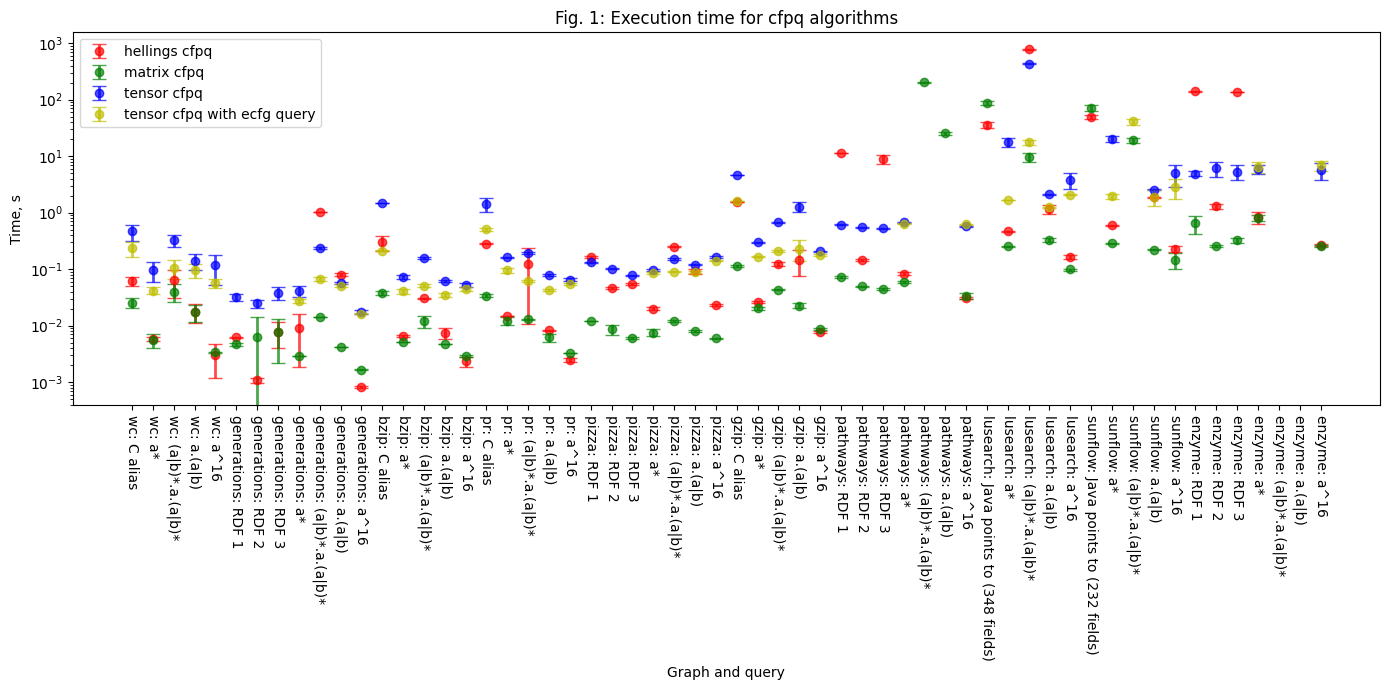

In [ ]:
show_plot(
    "Fig. 1: Execution time for cfpq algorithms",
    algorithm_filter=lambda algorithm_name: "cfpq" in algorithm_name,
)

Сравнение матричного алгоритма и алгоритма Хеллингса между собой показало, что все разы, когда алгоритма Хеллингса обогнал по времени матричный алгоритм, приходятся на запросы `a^16` и `Java points to`, а также на запрос `RDF 2` для графа `generations`, это можно более чётко видеть на следующих двух графиках.

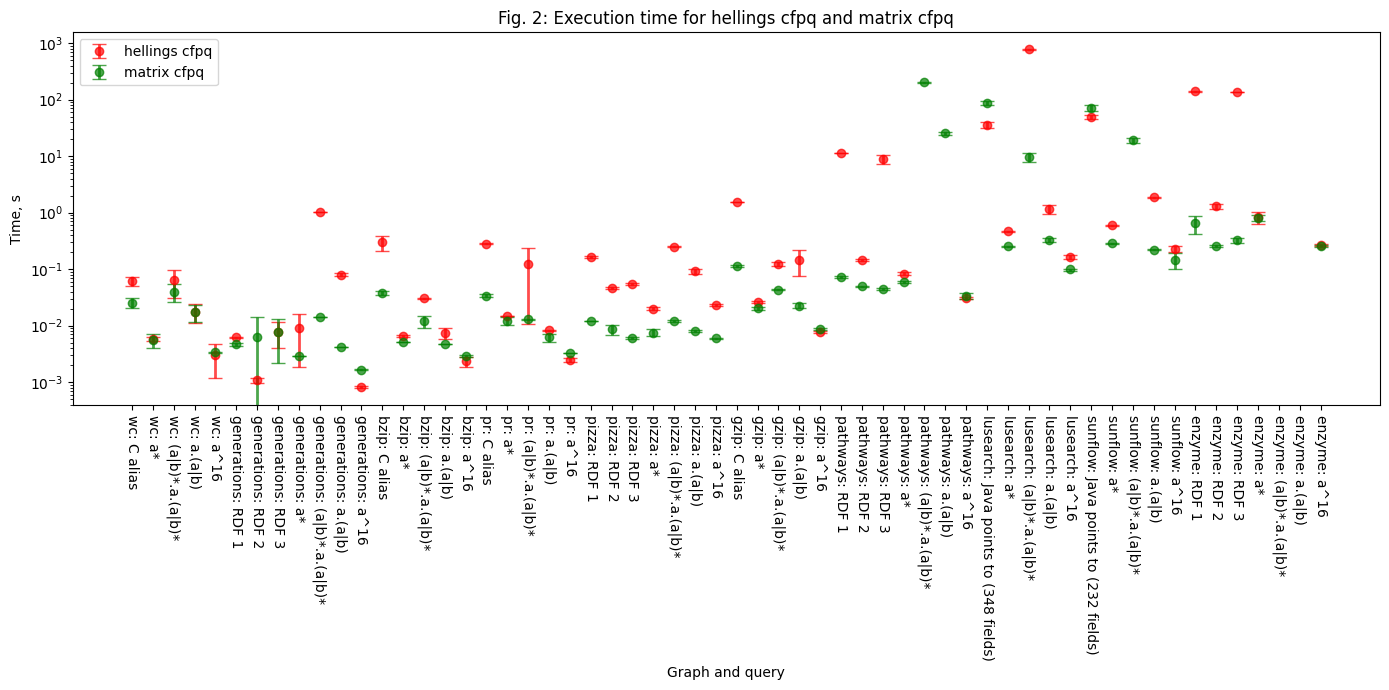

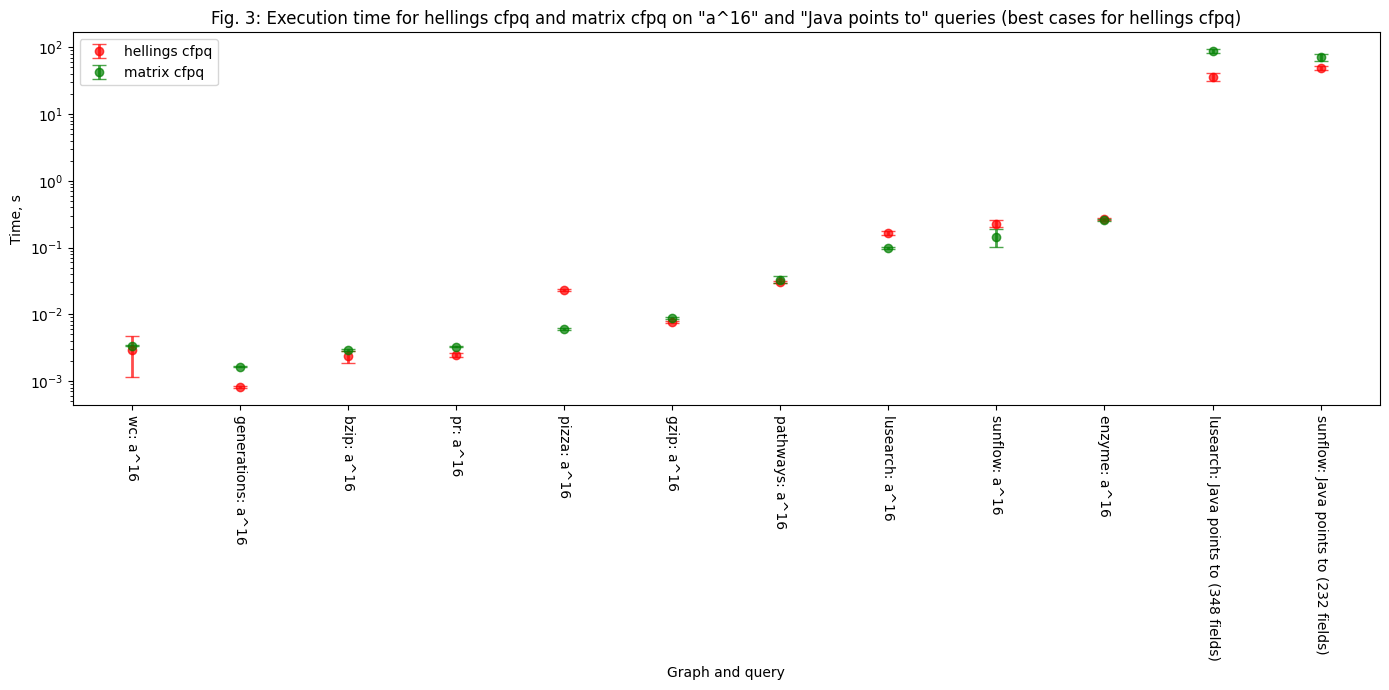

In [ ]:
show_plot(
    "Fig. 2: Execution time for hellings cfpq and matrix cfpq",
    algorithm_filter=lambda algorithm_name: algorithm_name
    in {"hellings cfpq", "matrix cfpq"},
)
show_plot(
    'Fig. 3: Execution time for hellings cfpq and matrix cfpq on "a^16" and "Java points to" queries (best cases for hellings cfpq)',
    algorithm_filter=lambda algorithm_name: algorithm_name
    in {"hellings cfpq", "matrix cfpq"},
    query_filter=lambda query_name: query_name == "a^16"
    or "Java points to" in query_name,
    modify_graphs_and_queries=lambda graphs_and_queries: sorted(
        graphs_and_queries,
        key=lambda graph_and_query: graph_and_query[1],
        reverse=True,
    ),
)

То, что алгоритм Хеллингса отработал быстрее матричного на запросе `RDF 2` для графа `generations` может быть обусловлено погрешностью измерений, так как в данном случае оба алгоритма отработали достаточно быстро, а также наблюдалось большое стандартное отклонение времени работы матричного алгоритма.

Несколько же выигрышей по времени алгоритма Хеллингса по сравнению с матричным алгоритмом в случае запросов `a^16` и `Java points to`, вероятно, обусловлены структурой множества кратчайших выводимых путей и их деревьев вывода.

### Определение того, имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений или всё же лучше использовать специализированные алгоритмы для регулярных ограничений

Сравнение времени работы специализированных алгоритмов для регулярных ограничений и алгоритмов для КС-ограничений показало, что в подавляющем большинстве случаев использование алгоритмов для КС-ограничений оказывается быстрее или незначительно медленнее специализированных алгоритмов для регулярных ограничений. Это можно видеть из следующего графика.

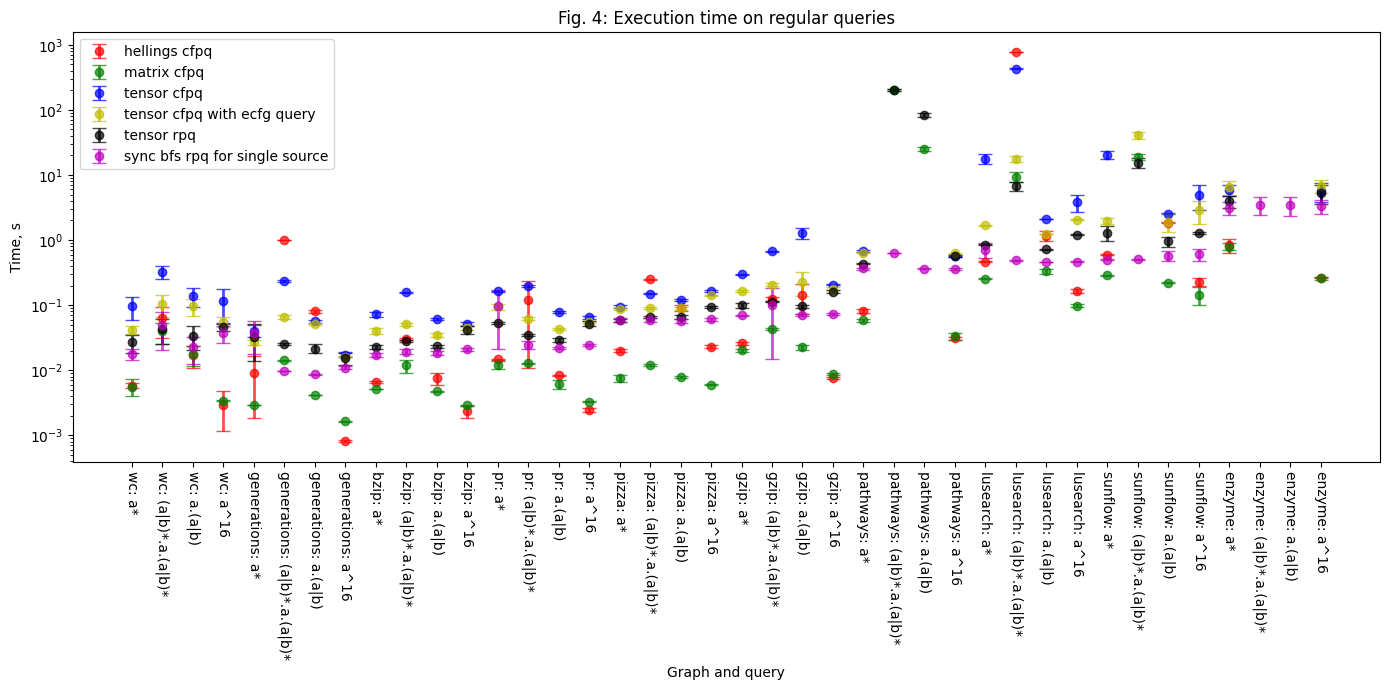

In [ ]:
REGULAR_QUERIES_NAMES, _, _ = zip(*REGULAR_QUERIES)
show_plot(
    "Fig. 4: Execution time on regular queries",
    query_filter=lambda query_name: query_name in REGULAR_QUERIES_NAMES,
)

Более того в подавляющем большинстве случаев специализированные алгоритмы для регулярных ограничений медленнее или незначительно быстрее одного конкретного алгоритма для КС-ограничений, а именно: матричного алгоритма. Это можно видеть из следующего графика.

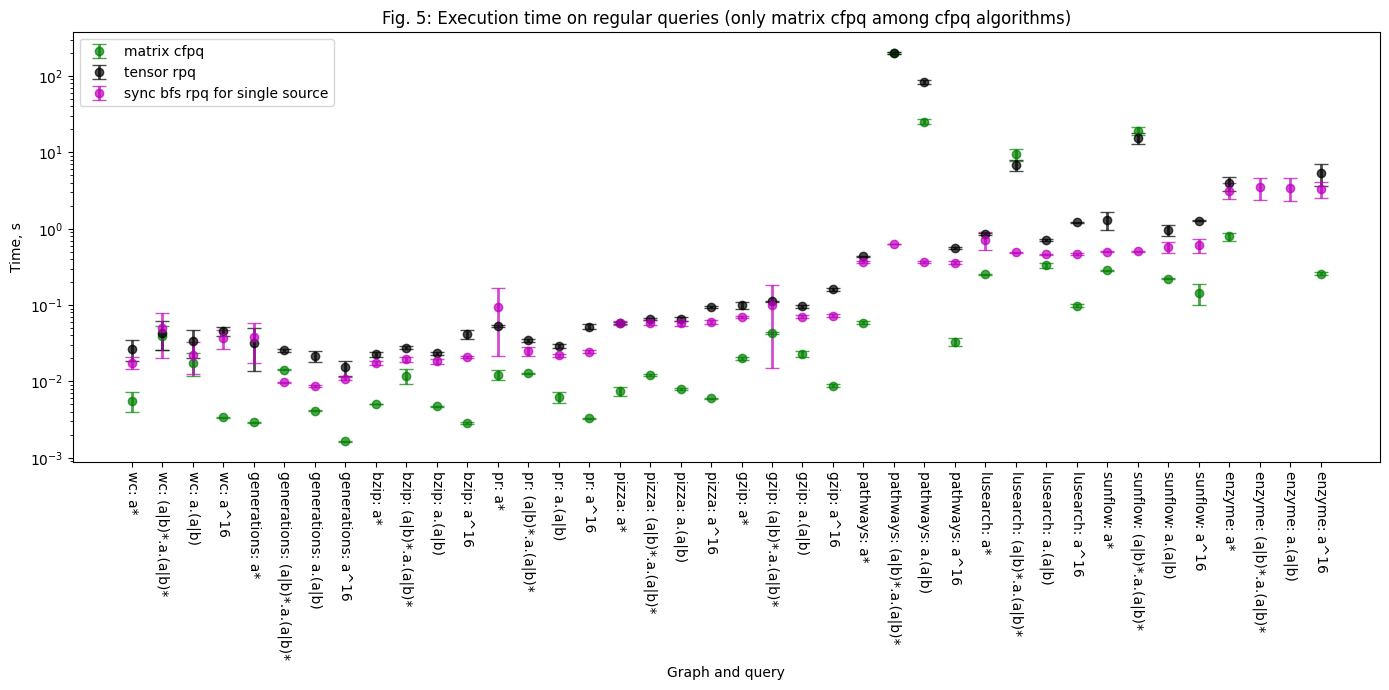

In [ ]:
show_plot(
    "Fig. 5: Execution time on regular queries (only matrix cfpq among cfpq algorithms)",
    algorithm_filter=lambda algorithm_name: algorithm_name
    in {"matrix cfpq", "tensor rpq", "sync bfs rpq for single source"},
    query_filter=lambda query_name: query_name in REGULAR_QUERIES_NAMES,
)

Однако в отдельных случаях все алгоритмы для КС-ограничений значительно (на порядки) уступают алгоритму синхронного обхода в ширину, решающему задачу для одной единственной стартовой вершины, что может объясняться тем что алгоритму синхронного обхода не всегда надо работать со всем графом, так как обход может завершиться после посещения небольшого числа вершин.

Также, в ещё более маленьком числе случаев наблюдалось более быстрое выполнение тензорного алгоритма для регулярных запросов по сравнению со всеми алгоритмами для КС-ограничений.

Далее приведён график только для упомянутых исключительных случаев (в столбце `pathways: (a|b)*.a.(a|b)*` результаты для `tensor rpq` и `matrix cfpq` практически совпадают, см. приложение).

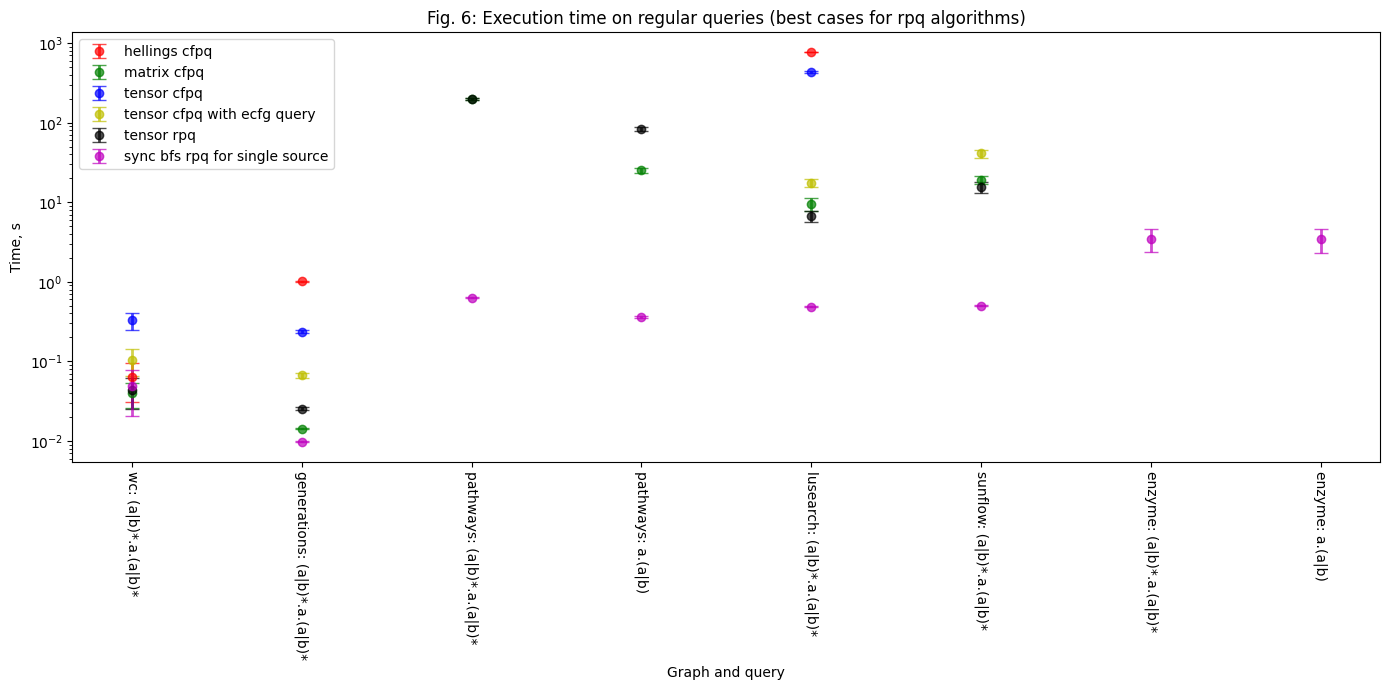

In [ ]:
show_plot(
    "Fig. 6: Execution time on regular queries (best cases for rpq algorithms)",
    query_filter=lambda query_name: query_name in REGULAR_QUERIES_NAMES,
    modify_graphs_and_queries=lambda _: [
        ("wc", "(a|b)*.a.(a|b)*"),
        ("generations", "(a|b)*.a.(a|b)*"),
        ("pathways", "(a|b)*.a.(a|b)*"),
        ("pathways", "a.(a|b)"),
        ("lusearch", "(a|b)*.a.(a|b)*"),
        ("sunflow", "(a|b)*.a.(a|b)*"),
        ("enzyme", "(a|b)*.a.(a|b)*"),
        ("enzyme", "a.(a|b)"),
    ],
)

## Заключение

По результатам экспериментального исследования были сделаны следующие выводы
1. Наиболее эффективным по скорости работы среди алгоритмов для КС-ограничений во всех рассмотренных случаях является либо матричный алгоритм, либо алгоритм Хеллингса, причём среди этих двух в большинстве случаев быстрее матричный алгоритм
2. За несколькими исключениями для решения задачи достижимости с регулярными ограничениями использование алгоритмов для КС-ограничений, а не специализированные алгоритмы для регулярных ограничений, целесообразно и имеет смысл, особенно когда требуется решить задачу достижимости для всех пар вершин

## Приложение

Далее приведены результаты проведённых замеров в виде достаточно "сырых" данных

In [26]:
data = []
for (graph_name, query_name, algorithm_name, mean, std, _) in res:
    if np.isfinite(mean):
        presion = max(0, math.ceil(-math.log10(std)))
        mean_with_std = f"{mean:.{presion}f} ± {std:.{presion}f}"
    else:
        mean_with_std = "Didn't finish"
    data.append(
        (
            graph_name,
            query_name,
            algorithm_name,
            mean_with_std,
        )
    )
pd.DataFrame(
    data,
    columns=["algorithm", "graph", "regex", "mean time ± σ, s"],
)

,algorithm,graph,regex,"mean time ± σ, s"
0,wc,C alias,hellings cfpq,0.06 ± 0.01
1,wc,C alias,matrix cfpq,0.026 ± 0.005
2,wc,C alias,tensor cfpq,0.5 ± 0.1
3,wc,C alias,tensor cfpq with ecfg query,0.23 ± 0.07
4,wc,a*,hellings cfpq,0.0058 ± 0.0005
5,wc,a*,matrix cfpq,0.006 ± 0.002
6,wc,a*,tensor cfpq,0.10 ± 0.04
7,wc,a*,tensor cfpq with ecfg query,0.042 ± 0.006
8,wc,a*,tensor rpq,0.027 ± 0.008
9,wc,a*,sync bfs rpq for single source,0.018 ± 0.003
